### --------Import the libraries---------

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import string
import numpy as np
import re
#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import tokenize

#sci-kit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


### --------EDA-----------

In [2]:
nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [3]:
from nltk.corpus import movie_reviews

In [4]:
len(movie_reviews.fileids())

2000

In [5]:
movie_reviews.fileids()[:5]

['neg/cv000_29416.txt',
 'neg/cv001_19502.txt',
 'neg/cv002_17424.txt',
 'neg/cv003_12683.txt',
 'neg/cv004_12641.txt']

In [6]:
movie_reviews.fileids()[-5:]

['pos/cv995_21821.txt',
 'pos/cv996_11592.txt',
 'pos/cv997_5046.txt',
 'pos/cv998_14111.txt',
 'pos/cv999_13106.txt']

In [7]:
negative_fileids = movie_reviews.fileids('neg')
positive_fileids = movie_reviews.fileids('pos')

In [8]:
negative_fileids

['neg/cv000_29416.txt',
 'neg/cv001_19502.txt',
 'neg/cv002_17424.txt',
 'neg/cv003_12683.txt',
 'neg/cv004_12641.txt',
 'neg/cv005_29357.txt',
 'neg/cv006_17022.txt',
 'neg/cv007_4992.txt',
 'neg/cv008_29326.txt',
 'neg/cv009_29417.txt',
 'neg/cv010_29063.txt',
 'neg/cv011_13044.txt',
 'neg/cv012_29411.txt',
 'neg/cv013_10494.txt',
 'neg/cv014_15600.txt',
 'neg/cv015_29356.txt',
 'neg/cv016_4348.txt',
 'neg/cv017_23487.txt',
 'neg/cv018_21672.txt',
 'neg/cv019_16117.txt',
 'neg/cv020_9234.txt',
 'neg/cv021_17313.txt',
 'neg/cv022_14227.txt',
 'neg/cv023_13847.txt',
 'neg/cv024_7033.txt',
 'neg/cv025_29825.txt',
 'neg/cv026_29229.txt',
 'neg/cv027_26270.txt',
 'neg/cv028_26964.txt',
 'neg/cv029_19943.txt',
 'neg/cv030_22893.txt',
 'neg/cv031_19540.txt',
 'neg/cv032_23718.txt',
 'neg/cv033_25680.txt',
 'neg/cv034_29446.txt',
 'neg/cv035_3343.txt',
 'neg/cv036_18385.txt',
 'neg/cv037_19798.txt',
 'neg/cv038_9781.txt',
 'neg/cv039_5963.txt',
 'neg/cv040_8829.txt',
 'neg/cv041_22364.txt',


In [9]:
len(negative_fileids), len(positive_fileids)

(1000, 1000)

In [10]:
print(movie_reviews.raw(fileids=positive_fileids[20]))

by phil curtolo mel gibson ( braveheart ) gave a gripping performance as the father of a young kidnapped boy in ron howard's ransom . 
gibson plays tom mullen , a wealthy business tycoon whose past actions are coming back to haunt him as a deranged psychopath , played by gary sinise ( forrest gump ) , and his band of low-life thugs kidnap his only son for $2 million . 
tom and his wife , kate , played by rene russo ( tin cup ) were instructed not to inform the police , but they contacted the fbi . 
minutes later , an elite team of agents led by delroy lindo ( broken arrow ) are in tom's house and wiring every phone . 
the plot sounds average , just like most other kidnap movies that you've already seen , and it was nothing more than that . 
that is until about half-way through the movie . 
suddenly , tom goes to the fox 5 news room and makes a live broadcast saying , " this is your ransom . 
but this is as close as you will ever get to it . 
instead , i am offering this money as a rewa

In [11]:
negative_fileids[2]

'neg/cv002_17424.txt'

In [12]:
negative_features = pd.DataFrame(
    {'review':movie_reviews.raw(fileids=[f]),'label': 'neg'} for f in negative_fileids
)

In [13]:
positive_features = pd.DataFrame(
    {'review':movie_reviews.raw(fileids=[f]),'label': 'pos'} for f in positive_fileids
)

In [14]:
data = pd.concat([positive_features, negative_features], ignore_index=True)


In [15]:
data

,review,label
0,films adapted from comic books have had plenty...,pos
1,every now and then a movie comes along from a ...,pos
2,you've got mail works alot better than it dese...,pos
3,""" jaws "" is a rare film that grabs your atten...",pos
4,moviemaking is a lot like being the general ma...,pos
...,...,...
1995,"if anything , "" stigmata "" should be taken as ...",neg
1996,"john boorman's "" zardoz "" is a goofy cinematic...",neg
1997,the kids in the hall are an acquired taste . \...,neg
1998,there was a time when john carpenter was a gre...,neg


### --------data Preprocessing--------

In [16]:
data['review'] = data['review'].str.lower()

In [17]:
data.review[2]

"you've got mail works alot better than it deserves to . \nin order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . \nno real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . \nessentially , it goes against and defies all concepts of good contemporary filmmaking . \nit's overly sentimental and at times terribly mushy , not to mention very manipulative . \nbut oh , how enjoyable that manipulation is . \nbut there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previous ryan/hanks teaming , sleepless in seattle . \nit couldn't have been the directing , because both films were helmed by the same woman . \ni haven't quite yet figured out wh

In [18]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
data['review']=data['review'].apply(lambda x : decontracted(x))

In [20]:
punctuations = list(string.punctuation)
print(punctuations)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [21]:
import re
data['review'] = data['review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [22]:
data['review'] = data['review'].apply(lambda x: re.sub(r'[0-9]', '',x))

In [23]:
#verification
data.review[2]

'you have got mail works alot better than it deserves to  \nin order to make the film a success  all they had to do was cast two extremely popular and attractive stars  have them share the screen for about two hours and then collect the profits  \nno real acting was involved and there is not an original or inventive bone in it is body  it is basically a complete reshoot of the shop around the corner  only adding a few modern twists   \nessentially  it goes against and defies all concepts of good contemporary filmmaking  \nit is overly sentimental and at times terribly mushy  not to mention very manipulative  \nbut oh  how enjoyable that manipulation is  \nbut there must be something other than the casting and manipulation that makes the movie work as well as it does  because i absolutely hated the previous ryanhanks teaming  sleepless in seattle  \nit could not have been the directing  because both films were helmed by the same woman  \ni have not quite yet figured out what i liked so 

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stop = stopwords.words('english')

In [26]:
print('Total stop words:',len(stop))

Total stop words: 179


In [27]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

data['review'] = data['review'].apply(lambda x: remove_stopwords(x))

In [28]:
data["review"] = data["review"].apply(lambda x: re.sub(' +', ' ', x))

In [29]:
data["review"] = data["review"].apply(lambda x: re.sub(r'aa+', 'a', x))

In [30]:
#verification
data.review[2]

'got mail works alot better deserves order make film success cast two extremely popular attractive stars share screen two hours collect profits real acting involved original inventive bone body basically complete reshoot shop around corner adding modern twists essentially goes defies concepts good contemporary filmmaking overly sentimental times terribly mushy mention manipulative oh enjoyable manipulation must something casting manipulation makes movie work well absolutely hated previous ryanhanks teaming sleepless seattle could directing films helmed woman quite yet figured liked much got mail really important like something much even question storyline cliched come tom hanks plays joe fox insanely likeable owner discount book chain meg ryan plays kathleen kelley even insanely likeable proprietor familyrun children book shop called nice homage shop around corner fox kelley soon become bitter rivals new fox books store opening right across block small business little know already love

In [31]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
data['review'] = data['review'].apply(lambda x: word_tokenize(x))

In [33]:
data['review']

0       [films, adapted, comic, books, plenty, success...
1       [every, movie, comes, along, suspect, studio, ...
2       [got, mail, works, alot, better, deserves, ord...
3       [jaws, rare, film, grabs, attention, shows, si...
4       [moviemaking, lot, like, general, manager, nfl...
                              ...                        
1995    [anything, stigmata, taken, warning, releasing...
1996    [john, boorman, zardoz, goofy, cinematic, deba...
1997    [kids, hall, acquired, taste, took, least, sea...
1998    [time, john, carpenter, great, horror, directo...
1999    [two, party, guys, bob, heads, haddaway, dance...
Name: review, Length: 2000, dtype: object

In [34]:
data['review']

0       [films, adapted, comic, books, plenty, success...
1       [every, movie, comes, along, suspect, studio, ...
2       [got, mail, works, alot, better, deserves, ord...
3       [jaws, rare, film, grabs, attention, shows, si...
4       [moviemaking, lot, like, general, manager, nfl...
                              ...                        
1995    [anything, stigmata, taken, warning, releasing...
1996    [john, boorman, zardoz, goofy, cinematic, deba...
1997    [kids, hall, acquired, taste, took, least, sea...
1998    [time, john, carpenter, great, horror, directo...
1999    [two, party, guys, bob, heads, haddaway, dance...
Name: review, Length: 2000, dtype: object

In [35]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [36]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(list):
    return ([lemmatizer.lemmatize(word) for word in list])
data["review"] = data["review"].apply(lambda text: lemmatize_words(text))

In [37]:
list_of_docs = data.sample(100)['review'].tolist()

In [38]:
list_of_docs

[['take',
  'two',
  'old',
  'dying',
  'men',
  'lifetime',
  'regret',
  'house',
  'full',
  'sin',
  'thoroughly',
  'despicable',
  'man',
  'enough',
  'lie',
  'insecurity',
  'character',
  'defect',
  'keep',
  'team',
  'psychiatrist',
  'gainfully',
  'employed',
  'add',
  'inexplicable',
  'meteorological',
  'amphibianbased',
  'phenomenon',
  'summed',
  'magnolia',
  'newest',
  'film',
  'paul',
  'thomas',
  'anderson',
  'boogie',
  'night',
  'movie',
  'tell',
  'multiple',
  'story',
  'weaving',
  'together',
  'overlapping',
  'course',
  'three',
  'hour',
  'running',
  'time',
  'would',
  'story',
  'worth',
  'telling',
  'earl',
  'partridge',
  'jason',
  'robards',
  'thousand',
  'acre',
  'dying',
  'cancer',
  'bedridden',
  'much',
  'pain',
  'obvious',
  'time',
  'growing',
  'short',
  'much',
  'younger',
  'wife',
  'played',
  'julianne',
  'moore',
  'ideal',
  'husband',
  'surprised',
  'find',
  'struggling',
  'impending',
  'death',
  '

### -----------LDA_bow-----------

In [39]:
import gensim
from gensim import corpora
import string
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(list_of_docs)

# Creating the corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in list_of_docs]

# Creating the LDA model
ldamodel_bow = LdaModel(corpus=doc_term_matrix, num_topics=4,id2word=dictionary, random_state=2022, passes=30)

In [40]:
from pprint import pprint

pprint(ldamodel_bow.print_topics())

[(0,
  '0.010*"film" + 0.007*"movie" + 0.007*"one" + 0.005*"character" + '
  '0.004*"time" + 0.004*"like" + 0.003*"make" + 0.003*"would" + 0.003*"love" + '
  '0.003*"story"'),
 (1,
  '0.012*"film" + 0.007*"movie" + 0.006*"one" + 0.004*"character" + '
  '0.003*"life" + 0.003*"get" + 0.003*"make" + 0.003*"like" + 0.003*"go" + '
  '0.003*"story"'),
 (2,
  '0.015*"film" + 0.007*"one" + 0.007*"movie" + 0.005*"like" + '
  '0.004*"character" + 0.004*"time" + 0.003*"story" + 0.003*"would" + '
  '0.003*"scene" + 0.003*"even"'),
 (3,
  '0.011*"movie" + 0.009*"film" + 0.007*"character" + 0.007*"one" + '
  '0.004*"like" + 0.004*"well" + 0.003*"life" + 0.003*"make" + 0.003*"would" + '
  '0.003*"scene"')]


### ----------LSI----------

In [41]:
from gensim.models.lsimodel import LsiModel
lsimodel = LsiModel(corpus=doc_term_matrix, num_topics=5, id2word=dictionary)
pprint(lsimodel.print_topics())

[(0,
  '0.526*"film" + 0.297*"movie" + 0.250*"one" + 0.211*"character" + '
  '0.145*"like" + 0.114*"scene" + 0.114*"would" + 0.112*"time" + 0.106*"make" '
  '+ 0.100*"story"'),
 (1,
  '0.541*"film" + -0.514*"movie" + 0.156*"scream" + -0.115*"nomi" + 0.087*"mr" '
  '+ -0.087*"one" + 0.087*"fight" + -0.086*"like" + 0.081*"williamson" + '
  '-0.076*"tarzan"'),
 (2,
  '-0.365*"scream" + -0.208*"character" + -0.200*"movie" + 0.181*"fight" + '
  '-0.158*"williamson" + -0.136*"sidney" + -0.129*"sequel" + 0.119*"one" + '
  '0.117*"effect" + 0.113*"must"'),
 (3,
  '0.285*"movie" + 0.227*"fight" + 0.182*"scene" + 0.166*"kong" + 0.166*"hong" '
  '+ 0.151*"jet" + 0.141*"must" + 0.140*"nomi" + 0.130*"romeo" + 0.121*"li"'),
 (4,
  '-0.408*"tarzan" + 0.224*"character" + -0.223*"lost" + -0.192*"city" + '
  '0.174*"life" + -0.169*"bad" + -0.163*"jane" + -0.154*"jungle" + '
  '-0.137*"even" + -0.129*"movie"')]


### ---------LDA_tfidf--------

In [42]:
from gensim import models
tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

In [43]:

ldamodel_tf = LdaModel(corpus=corpus_tfidf, num_topics=4,id2word=dictionary, random_state=2022, passes=30)

pprint(ldamodel_tf.print_topics())

[(0,
  '0.000*"tarzan" + 0.000*"eddie" + 0.000*"mamet" + 0.000*"nikki" + '
  '0.000*"sherri" + 0.000*"scream" + 0.000*"alien" + 0.000*"truman" + '
  '0.000*"roxbury" + 0.000*"batman"'),
 (1,
  '0.000*"rico" + 0.000*"dwayne" + 0.000*"lucy" + 0.000*"kimble" + '
  '0.000*"fanny" + 0.000*"clooney" + 0.000*"leo" + 0.000*"sex" + '
  '0.000*"borrower" + 0.000*"nomi"'),
 (2,
  '0.000*"magoo" + 0.000*"rugrats" + 0.000*"li" + 0.000*"gloria" + 0.000*"jet" '
  '+ 0.000*"monkey" + 0.000*"melvin" + 0.000*"lambeau" + 0.000*"truman" + '
  '0.000*"emily"'),
 (3,
  '0.000*"grinch" + 0.000*"beatty" + 0.000*"allen" + 0.000*"babysitter" + '
  '0.000*"grodin" + 0.000*"beautiful" + 0.000*"toy" + 0.000*"stuart" + '
  '0.000*"chocolat" + 0.000*"school"')]


In [44]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel_bow, texts=list_of_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_bow = coherence_model_lda.get_coherence()
coherence_model_lda1 = CoherenceModel(model=ldamodel_tf, texts=list_of_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_tf = coherence_model_lda1.get_coherence()
coherence_model_lsi = CoherenceModel(model=lsimodel, texts=list_of_docs, dictionary=dictionary, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score of LDA used on Bag of words : ', coherence_lda_bow)
print('\nCoherence Score of LDA used on TF IDF : ', coherence_lda_tf)
print('\nCoherence Score of LSI model : ', coherence_lsi)


Coherence Score of LDA used on Bag of words :  0.25544583985595554

Coherence Score of LDA used on TF IDF :  0.7204976795582536

Coherence Score of LSI model :  0.31947006620475593


In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, step, start=2):
 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [46]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=list_of_docs, start=2, limit=8, step=1)


In [47]:
coherence_values

[0.3847979131826763,
 0.6282817516278617,
 0.6854859074129946,
 0.7094063960311122,
 0.7036423972565653,
 0.6704419460924804]

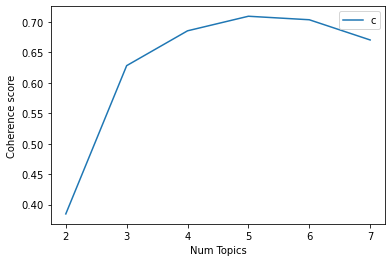

In [48]:
import matplotlib.pyplot as plt
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### ----------Visualizations-----------

#### WordCloud

In [49]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel_tf.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig.savefig('word_cloud.png')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

#### pyLDAvis

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(ldamodel_tf, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

In [54]:
pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\hp\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\hp\\AppData\\Local\\Temp\\pip-install-nz03rfao\\wordcloud_89223371ec3346e8b4f4b80e8e459536\\setup.py'"'"'; __file__='"'"'C:\\Users\\hp\\AppData\\Local\\Temp\\pip-install-nz03rfao\\wordcloud_89223371ec3346e8b4f4b80e8e459536\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\hp\AppData\Local\Temp\pip-wheel-0yc0eufa'
       cwd: C:\Users\hp\AppData\Local\Temp\pip-install-nz03rfao\wordcloud_89223371ec3346e8b4f4b80e8e459536\
  Complete output (20 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.9
  creating bui


  Running setup.py clean for wordcloud
Failed to build wordcloud
    Running setup.py install for wordcloud: started
    Running setup.py install for wordcloud: finished with status 'error'



  copying wordcloud\__main__.py -> build\lib.win-amd64-3.9\wordcloud
  copying wordcloud\stopwords -> build\lib.win-amd64-3.9\wordcloud
  copying wordcloud\DroidSansMono.ttf -> build\lib.win-amd64-3.9\wordcloud
  UPDATING build\lib.win-amd64-3.9\wordcloud/_version.py
  set build\lib.win-amd64-3.9\wordcloud/_version.py to '1.8.1'
  running build_ext
  building 'wordcloud.query_integral_image' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  ----------------------------------------
  ERROR: Failed building wheel for wordcloud
    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\hp\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\hp\\AppData\\Local\\Temp\\pip-install-nz03rfao\\wordcloud_89223371ec3346e8b4f4b80e8e459536\\setup.py'"'"'; __file__='"'"'C:\\Users\\hp\\AppData\\Local\\Temp\\pip-instal

##### Split data

In [ ]:
from sklearn.model_selection import train_test_split
dataTrain, dataTest = train_test_split(data,train_size=0.8,random_state=1,stratify=data['label'])

In [ ]:
dataTest.groupby(['label']).size()

In [ ]:
dataTrain.groupby(['label']).size()

__Bag of Words using CountVectorizer:__


In [ ]:
count_vector = CountVectorizer(stop_words='english',min_df = 5) 

In [ ]:
X = count_vector.fit_transform(dataTrain['review'])

In [ ]:
bow_vectorizer_features = X.toarray()
bow_frequency_matrix = pd.DataFrame(bow_vectorizer_features,columns=count_vector.get_feature_names())
bow_frequency_matrix

In [ ]:
print(len(count_vector.get_feature_names()))

### ---------Building Classifier----------

#### KNN Classifier

In [ ]:
#import the class KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

#instatiate the object
knn_classifier = KNeighborsClassifier(n_neighbors=2)

#perform the training process
knn_classifier.fit(bow_frequency_matrix,dataTrain['label'])



In [ ]:
#generate the document term matrix for the test set
#using the object learned from the train set
#import the metrics class for the performance measurement
from sklearn import metrics

#create the document term matrix
bow_test = count_vector.transform(dataTest['review'])

#prediction for the test set
bow_pred = knn_classifier.predict(bow_test)

#confusion matrix
print('***Confusion matrix')
print(metrics.confusion_matrix(dataTest['label'],bow_pred))

In [ ]:
#recall
print('Recall')
print(metrics.recall_score(dataTest['label'],bow_pred,pos_label='pos'))

#precision
print('precision')
print(metrics.precision_score(dataTest['label'],bow_pred,pos_label='pos'))

#F1-Score
print('F1-Score')
print(metrics.f1_score(dataTest['label'],bow_pred,pos_label='pos'))

#accuracy rate
print('accuracy rate -->')
print(metrics.accuracy_score(dataTest['label'],bow_pred))

#### RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()

#perform the training process
rf.fit(bow_frequency_matrix,dataTrain['label'])


tf_test = count_vector.transform(dataTest['review'])

#prediction for the test set
tf_pred = rf.predict(tf_test)

#confusion matrix
print('***Confusion matrix')
mcTestBis = metrics.confusion_matrix(dataTest['label'],tf_pred)
print(mcTestBis)

#recall
print('Recall')
print(metrics.recall_score(dataTest['label'],tf_pred,pos_label='pos'))

#precision
print('precision')
print(metrics.precision_score(dataTest['label'],tf_pred,pos_label='pos'))

#F1-Score
print('F1-Score')
print(metrics.f1_score(dataTest['label'],tf_pred,pos_label='pos'))

#accuracy rate
print('accuracy rate -->')
print(metrics.accuracy_score(dataTest['label'],tf_pred))

#### Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
#perform the training process
gbc.fit(bow_frequency_matrix,dataTrain['label'])


tf_test = count_vector.transform(dataTest['review'])

#prediction for the test set
tf_pred = gbc.predict(tf_test)

#confusion matrix
print('***Confusion matrix')
mcTestBis = metrics.confusion_matrix(dataTest['label'],tf_pred)
print(mcTestBis)

#recall
print('Recall')
print(metrics.recall_score(dataTest['label'],tf_pred,pos_label='pos'))

#precision
print('precision')
print(metrics.precision_score(dataTest['label'],tf_pred,pos_label='pos'))

#F1-Score
print('F1-Score')
print(metrics.f1_score(dataTest['label'],tf_pred,pos_label='pos'))

#accuracy rate
print('accuracy rate -->')
print(metrics.accuracy_score(dataTest['label'],tf_pred))

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

#instatiate the object
LR = LogisticRegression()

#perform the training process
LR.fit(bow_frequency_matrix,dataTrain['label'])


tf_test = count_vector.transform(dataTest['review'])

#prediction for the test set
tf_pred = LR.predict(tf_test)

#confusion matrix
print('***Confusion matrix')
mcTestBis = metrics.confusion_matrix(dataTest['label'],tf_pred)
print(mcTestBis)

#recall
print('Recall')
print(metrics.recall_score(dataTest['label'],tf_pred,pos_label='pos'))

#precision
print('precision')
print(metrics.precision_score(dataTest['label'],tf_pred,pos_label='pos'))

#F1-Score
print('F1-Score')
print(metrics.f1_score(dataTest['label'],tf_pred,pos_label='pos'))

#accuracy rate
print('accuracy rate -->')
print(metrics.accuracy_score(dataTest['label'],tf_pred))

### --------Dimensionality Reduction---------

In [ ]:
coef_abs = np.abs(LR.coef_[0,:])

In [ ]:
thresholds = np.percentile(coef_abs,[0,25,50,75,90,100])
print(thresholds)

In [ ]:
indices = np.where(coef_abs > thresholds[2])
print(len(indices[0]))

In [ ]:
mdtTrainTer = bow_vectorizer_features[:,indices[0]]#toutes les lignes et uniquement les colones 
mdtTestTer = bow_test[:,indices[0]]

#checking
print(mdtTrainTer.shape)
print(mdtTestTer.shape)

In [ ]:
#instatiate the object
modelTer = LogisticRegression()

#train a new classifier with selected terms
modelTer.fit(mdtTrainTer,dataTrain['label'])

#prediction on the test set
predTestTer = modelTer.predict(mdtTestTer)

#confusion matrix
mcTestTer = metrics.confusion_matrix(dataTest['label'],predTestTer)
print(mcTestTer)

### -------Deployement---------

In [ ]:
doc = ["This was so bad I couldn't finish it. The actresses are so bad at acting it feels like a bad comedy from minute one. The high rated reviews is obviously from friend/family and is pure BS."]
#document preprocessing
doc = decontracted(str(doc))
doc = str(doc).lower()
doc = re.sub('[%s]' % re.escape(string.punctuation), '' , str(doc))
doc = re.sub(r'[0-9]', '',str(doc))
doc  = re.sub(' +', ' ', str(doc))
doc = remove_stopwords(str(doc))

#get its description
desc = count_vector.transform([doc])
print(desc)

In [ ]:
#dense representation
dense_desc = desc.toarray()

#apply var. selection
dense_sel = dense_desc[:,indices[0]]

In [ ]:
dense_desc 

In [ ]:
pred_doc = modelTer.predict(dense_sel)
print(pred_doc)

In [ ]:
pred_proba = modelTer.predict_proba(dense_sel)
print(pred_proba)